In [1]:
import numpy as np
from numpy import sin, cos, tan, pi
from numpy import arctan as atan
from numpy import linalg as la

from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.ticker import LinearLocator
import matplotlib as mlp

import math
from math import factorial as fact
import scipy as sy

import time

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.5g" % x))

gas = 1000 #global array size

### Functions

In [2]:
#Plotters
def plot_polygon(p,R0):
    x,y = gen_polygon_cart(p,R0)
    f = 0*x
    width = 1.1*R0
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlim(-width,width), ax.set_ylim(-width,width)
    ax.set_xlabel('X position'), ax.set_ylabel('Y position')
    ax.set_title('{}-Sided Regular Polygon w/ Radius={}'.format(p,R0))
    ax.contourf(x,y,f)
    plt.show()

def plotter(x,y,z):
    fig, ax = plt.subplots()
    ax.contourf(x,y,z)
    plt.show()

def plot_zernike_all_m(n,p,R0):
    x,y = gen_polygon_cart(p,R0)
    ms = np.arange(-n,n+1,2)
    for m in ms:
        f = zernike_m(n,m)
        plotter(x,y,f)

def plot_zernike(n,p,R0):
    x,y = gen_polygon_cart(p,R0)
    f = zernike(n)
    plotter(x,y,f)

def plotter_approx_with_save(x,y,f,n):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title('o={} Zernike Approx.'.format(n))
    ax.contourf(x,y,f)
#    plt.savefig('/home/joe/Pictures/Polygon Tally/order{}_approx'.format(n))
    plt.show()

def plot_zernike_approx(n,p,R0):
    x,y = gen_polygon_cart(p,R0)
    f = 0
    for i in range(n+1):
        f += f_n(i,p,R0)
    plotter_approx_with_save(x,y,f,n)
    return

def plot_analytical(p,R0):
    x,y = gen_polygon_cart(p,R0)
    f = input_function(x,y)

    fig,ax = plt.subplots(figsize=(5,5))
    ax.set_title('Analytical Plot')
    ax.contourf(x,y,f)
    plt.savefig('/home/joe/Pictures/Polygon Tally/analytical')

In [3]:
#Generators
def gen_rhophi():
    rho = np.linspace(0,1,gas)
    phi = np.linspace(0,2*pi,gas)
    rho,phi = np.meshgrid(rho,phi)
    return rho,phi

def gen_uv(rho=gen_rhophi()[0],phi=gen_rhophi()[1]):
    u = rho*cos(phi)
    v = rho*sin(phi)
    return u,v

def internal_r_alpha(p,R0):
    alpha = pi/p

    phi = np.linspace(0,2*pi,gas)
    x = (phi+alpha)/(2*alpha)
    U = np.zeros_like(phi)

    for i in range(len(phi)):
        U[i] = phi[i] - int(x[i])*(2*alpha)

    R = R0*cos(alpha)/cos(U)
    ones = np.ones(gas)

    ones,R = np.meshgrid(ones,R)

    return R

#Polygon Generators
def gen_polygon_polar(p,R0):
    alpha = pi/p
    rho, phi = gen_rhophi()
    R = internal_r_alpha(p,R0)
    r = rho*R
    theta = phi
    return r, theta

def gen_polygon_cart(p,R0):
    r, theta = gen_polygon_polar(p,R0)
    x = r*cos(theta)
    y = r*sin(theta)
    return x,y

def polygon_area(p,R0):
    toRet = p * R0**2 * cos(pi/p)**2 * tan(pi/p)
    return toRet

In [4]:
#Making the Zernike Polynomials
def m_checker(n,m):
    valid_m = np.arange(-n,n+1,2)
    if (m in valid_m) == False:
        raise ValueError('choosen m value is invalid. examples of valid: m = -n, -n+2, -n+4, ..., n')
    return

def n_mn(n,m):
    if m != 0:
        toRet = (2*(n+1))**(1/2)
    else:
        toRet = ((2*(n+1))/(2))**(1/2)
    return toRet

def r_mn(n,m,rho):
    stop = int((n-abs(m))/2)
    toRet = 0
    for k in range(stop+1):
        top = (-1)**k * fact(n-k) * rho**(n-2*k)
        bot = fact(k) * fact(int((n+abs(m))/2 - k)) * fact(int((n-abs(m))/2 - k))
        toRet += top/bot
    return toRet

def zernike_m(n,m,rho=gen_rhophi()[0],phi=gen_rhophi()[1]):
    m_checker(n,m)
    if m >= 0:
        toRet = n_mn(n,m) * r_mn(n,m,rho) * cos(m*phi)
    else:
        toRet = -n_mn(n,m) * r_mn(n,m,rho) * sin(m*phi)
    return toRet

def zernike(n,rho=gen_rhophi()[0],phi=gen_rhophi()[1]):
    ms = np.arange(-n,n+1,2)
    toRet = 0
    for m in ms:
        toRet += zernike_m(n,m)
    return toRet

In [7]:
#F and all its children
def input_function(x,y):
    return 2*x**2 - y**2 + x**2*y - 4*x*y**2 + 5*x*y - 3*x + 5*y

def u_alpha(theta,alpha):
    x = (theta + alpha)/(2*alpha)
    x = x.astype(int)
    toRet = theta - x*(2*alpha)
    return toRet

def r_alpha(theta,R0,alpha):
    toRet = R0*cos(alpha)/cos(u_alpha(theta,alpha))
    return toRet

def c_mn(n,m,p,R0):
    alpha = pi/p

    theta = np.linspace(0,2*pi,gas)
    dtheta = theta[1]

    toRet = 0

    R = r_alpha(theta,R0,alpha)
    dr = R / (gas-1)
    r = np.linspace(0,R,gas)

    rho = (r / R)
#    _, phi = np.meshgrid(theta,theta) #not needed bc bleh

    Z = zernike_m(n,m,rho,theta)
    K = Z * r / R

    x = r*cos(theta)
    y = r*sin(theta)
    F = input_function(x,y)
    
    toRet = 1/pi * F * K * r * dr * dtheta / R**2
    toRet = np.sum(toRet)
    return toRet

def f_mn(n,m,p,R0):
    alpha = pi/p

    r,theta = gen_polygon_polar(p,R0)
    R = np.zeros_like(theta)

    glorp = np.linspace(0,2*pi,gas)
    gleep = r_alpha(glorp,R0,alpha)
    
    for i in range(len(theta[0])):
        R[i,:] = gleep[i]

    rho = r / R
    phi = theta

    Z = zernike_m(n,m,rho,phi)
    K = Z * r / R
    c = c_mn(n,m,p,R0)

    toRet = c * K
    return toRet

def f_n(n,p,R0):
    ms = np.arange(-n,n+1,2)
    toRet = 0
    
    for m in ms:
        toRet += f_mn(n,m,p,R0)

    return toRet

test = {'n': 1, 'm': 1, 'p': 8, 'R0': 5}
glip = {'p': 8, 'R0': 5}

### REAL Orthonormality

In [26]:
#Checking orthonormality
p, R0 = 8, 5
alpha = pi/p

glorp = {'n':9, 'm':3}

#Gleeple
theta = np.linspace(0,2*pi,gas)
dtheta = theta[1]

R = r_alpha(theta,R0,alpha)
dr = R / (gas-1)
r = np.linspace(0,R,gas)

#Normalizing
a = f_mn(**glorp, **glip)
b = np.sum(1/pi * a**2 * r * dr * dtheta)
a /= (b)**.5

np.sum(1/pi * a**2 * r * dr * dtheta)
#I am doing the integration right
np.sum(r * dr * dtheta), polygon_area(**glip)

(70.84862751073898, 70.71067811865476)

In [68]:
orthonormal_c_mn(**test)

-44.38491086407738

In [14]:
def orthonormal_c_mn(n,m,p,R0):
    alpha = pi/p

    theta = np.linspace(0,2*pi,gas)
    dtheta = theta[1]

    R = r_alpha(theta,R0,alpha)
    dr = R / (gas-1)
    r = np.linspace(0,R,gas)

    rho = (r / R)
    Z = zernike_m(n,m,rho,theta)
    
    K = Z * r / R
    b = np.sum(1/pi * K**2 * r * dr * dtheta / R**2)
    K /= b**(.5)
    
    x = r*cos(theta)
    y = r*sin(theta)
    F = input_function(x,y)
    
    toRet = 1/pi * F * K * r * dr * dtheta / R**2
    toRet = np.sum(toRet)
    
#    return np.sum(1/pi * K**2 * r * dr * dtheta / R**2)
    return toRet

def orthonormal_f_mn(n,m,p,R0):
    alpha = pi/p

    #################
    theta = np.linspace(0,2*pi,gas)
    dtheta = theta[1]

    R = r_alpha(theta,R0,alpha)
    dr = R / (gas-1)
    r = np.linspace(0,R,gas)
    ################
    
    r,theta = gen_polygon_polar(p,R0)
    R = np.zeros_like(theta)

    glorp = np.linspace(0,2*pi,gas)
    gleep = r_alpha(glorp,R0,alpha)
    
    for i in range(len(theta[0])):
        R[i,:] = gleep[i]

    rho = r / R
    phi = theta

    Z = zernike_m(n,m,rho,phi)
    
    K = Z * r / R
    b = np.sum(1/pi * K**2 * r * dr * dtheta / R**2)
    K /= b**(.5)
    
#    c = c_mn(n,m,p,R0) 
    c = orthonormal_c_mn(n,m,p,R0)

    toRet = c * K
    return toRet

def orthonormal_f_n(n,p,R0):
    ms = np.arange(-n,n+1,2)
    toRet = 0
    
    for m in ms:
        toRet += orthonormal_f_mn(n,m,p,R0)

    return toRet

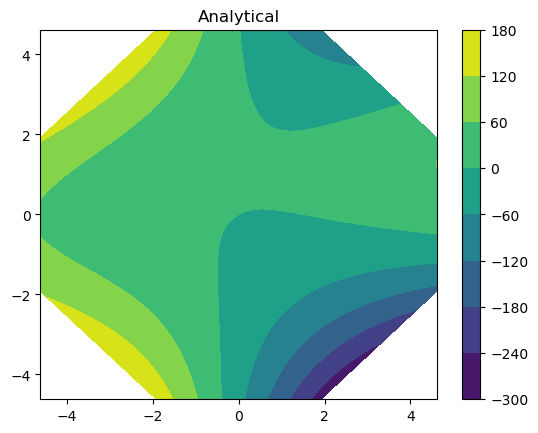

---------------0---------------


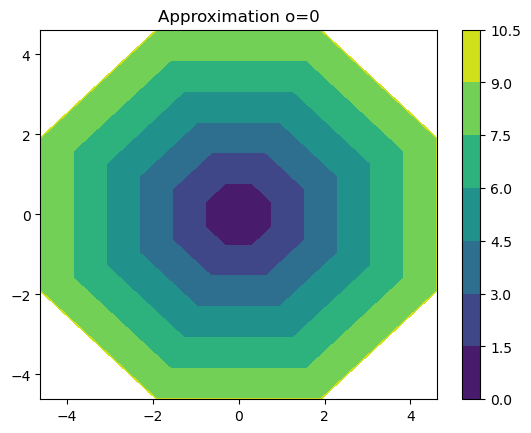

---------------1---------------


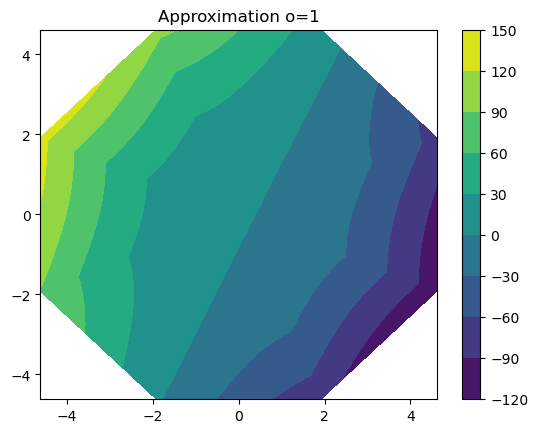

---------------2---------------


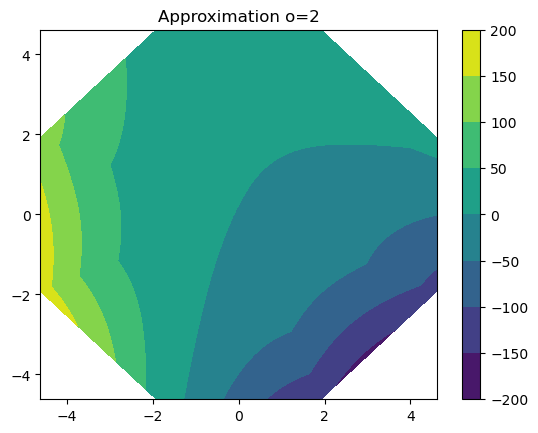

---------------3---------------


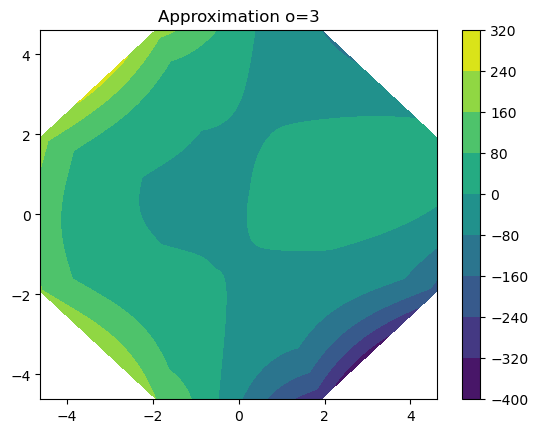

---------------4---------------


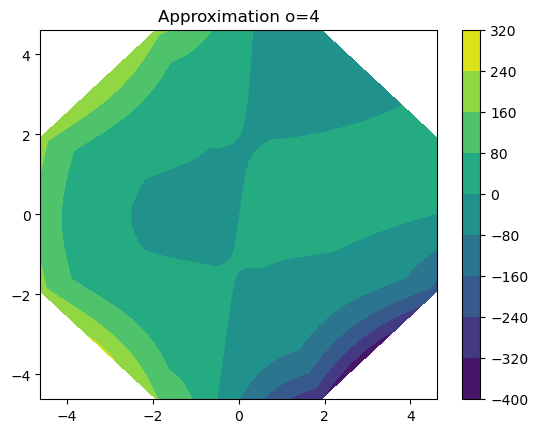

---------------5---------------


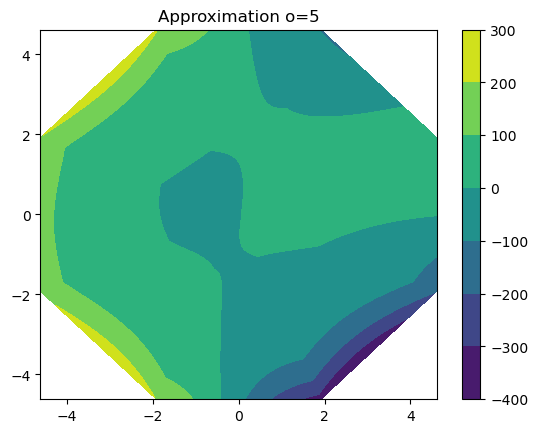

---------------6---------------


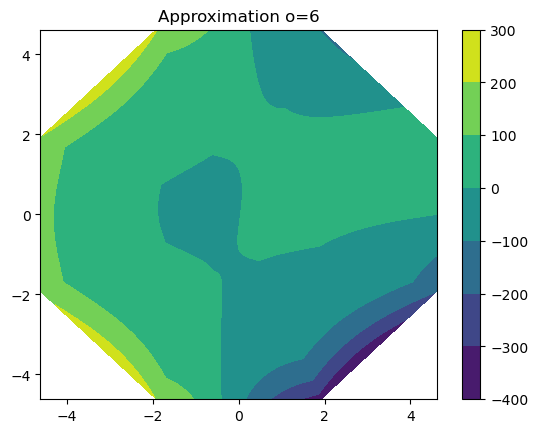

---------------7---------------


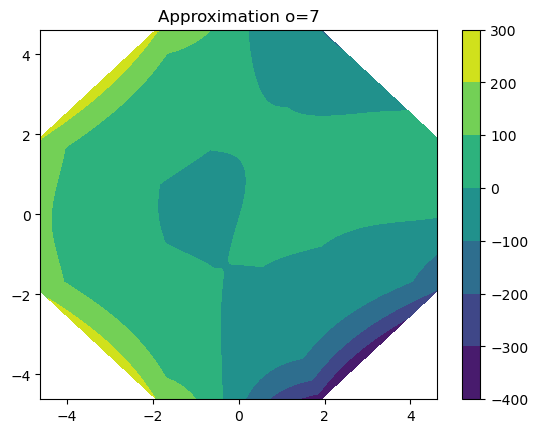

---------------8---------------


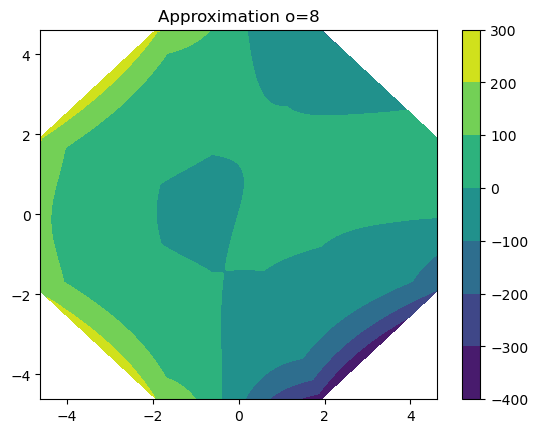

---------------9---------------


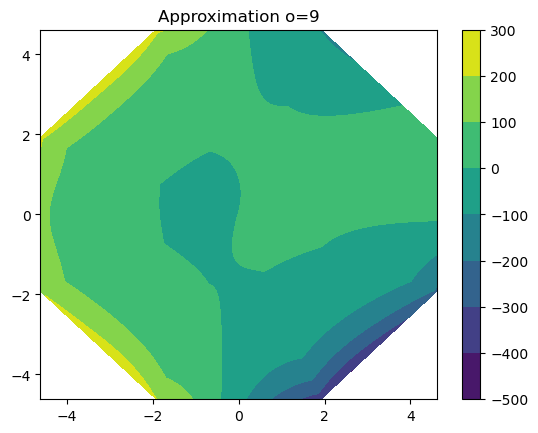

---------------10---------------


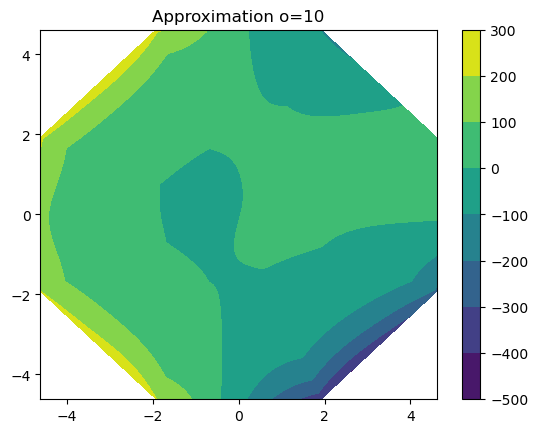

---------------11---------------


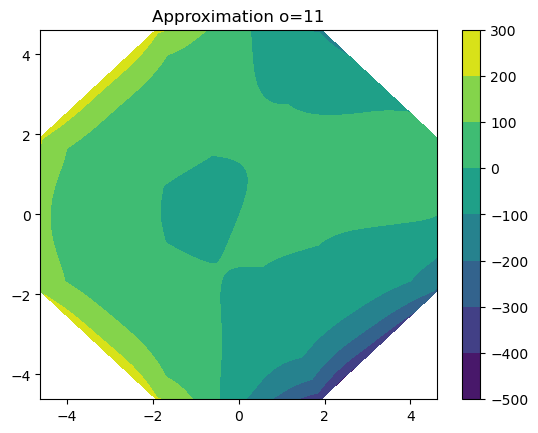

---------------12---------------


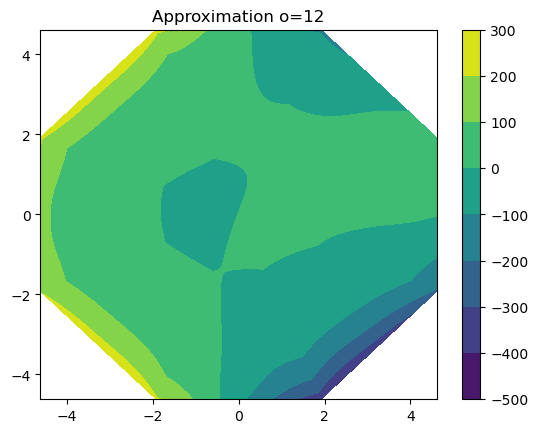

---------------13---------------


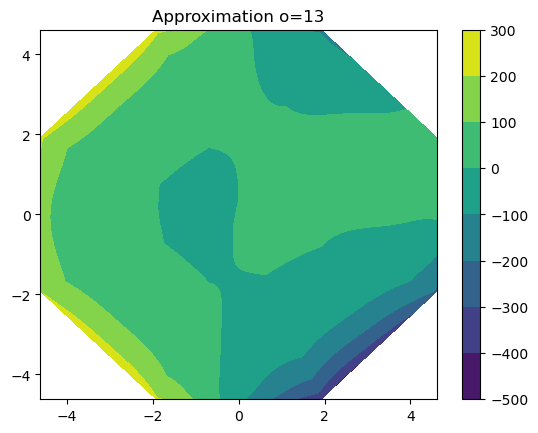

---------------14---------------


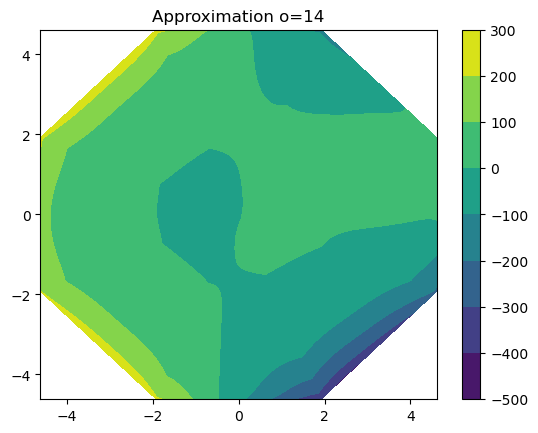

---------------15---------------


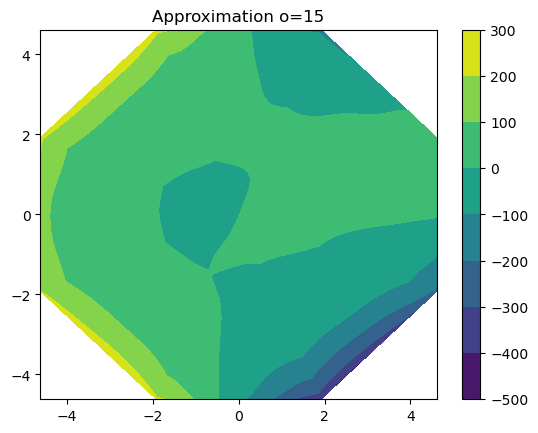

---------------16---------------


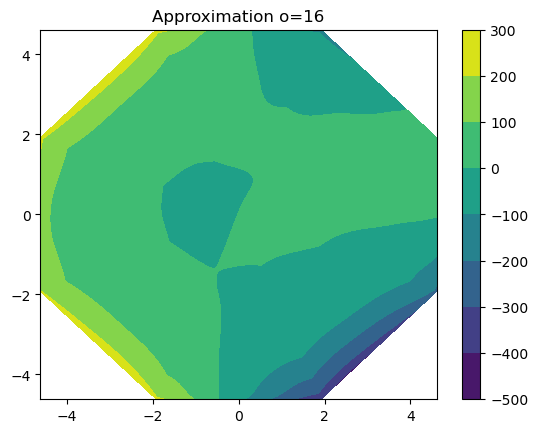

---------------17---------------


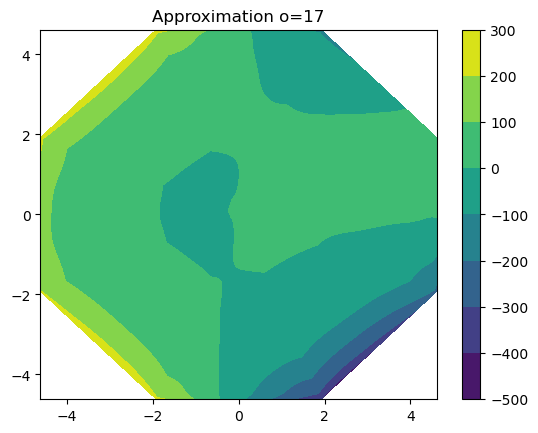

---------------18---------------


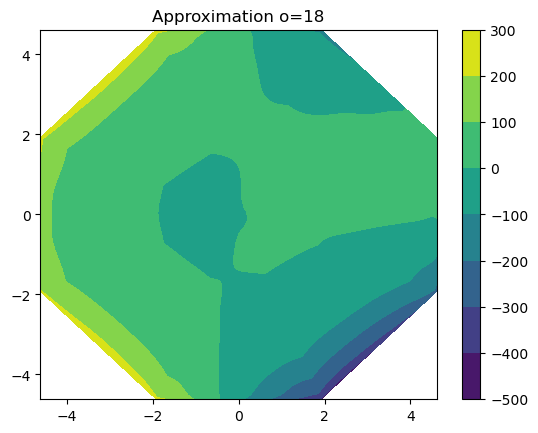

---------------19---------------


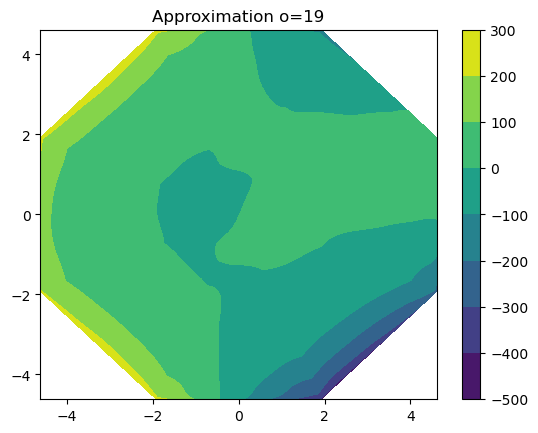

In [15]:
max_order = 20
x,y = gen_polygon_cart(**glip)
f1 = input_function(x,y)

#Analytical Plotting
fig, ax = plt.subplots()
ax.set_title('Analytical')
plot = ax.contourf(x,y,f1)
cbar = fig.colorbar(plot)
#plt.savefig(path+'analytical')
plt.show()

#Approximation
f2 = 0
for i in range(max_order):
    f2 += orthonormal_f_n(i,**glip)

    print('---------------{}---------------'.format(i))
    #Plotting Approx
    fig, ax = plt.subplots()
    ax.set_title('Approximation o={}'.format(i))
    plot = ax.contourf(x,y,f2)
    cbar = fig.colorbar(plot)
#    plt.savefig(path+'abs/approx_o{}'.format(i))
    plt.show()

    #Plotting Difference
#    fig, ax = plt.subplots()
#    ax.set_title('Difference o={}'.format(i))
#    plot = ax.contourf(x,y,f1-f2)
#    cbar = fig.colorbar(plot)
#    plt.savefig(path+'diff/diff_o{}'.format(i))
#    plt.show()

In [56]:
n = 15
p = 8
R0 = 5

x,y = gen_polygon_cart(p,R0)
f1 = input_function(x,y)

errs = []
times = []

t0 = time.time()
for j in range(n+1):
    f2 = 0
    for i in range(j+1):
        f2 += orthonormal_f_n(i,p,R0)
    err = la.norm(f1-f2,2) / la.norm(f1,2)
    te = time.time()
    errs.append(err)
    print('-----{}-----'.format(j))
    print('time:',te-t0)
    print('error:', errs[j])
    times.append(te-t0)

-----0-----
time: 0.48514771461486816
error: 0.9953979653091255
-----1-----
time: 1.3219683170318604
error: 0.6893457498679427
-----2-----
time: 2.528475284576416
error: 0.5682172273042476
-----3-----
time: 3.983518123626709
error: 0.31112666931628824
-----4-----
time: 5.9789299964904785
error: 0.3294474693412849
-----5-----
time: 8.759195327758789
error: 0.35703176784014995
-----6-----
time: 12.444096326828003
error: 0.3568521532534937
-----7-----
time: 17.18258547782898
error: 0.3569399977178183
-----8-----
time: 23.03268313407898
error: 0.3569710571876285
-----9-----
time: 30.220736265182495
error: 0.3572637922118912
-----10-----
time: 39.1825156211853
error: 0.3573090553516905
-----11-----
time: 50.03689646720886
error: 0.3573789427143225
-----12-----
time: 62.59312915802002
error: 0.3574164310764085
-----13-----
time: 77.65661334991455
error: 0.35769739923626015
-----14-----
time: 94.38472199440002
error: 0.3577378637919437
-----15-----
time: 113.41155815124512
error: 0.3580220155

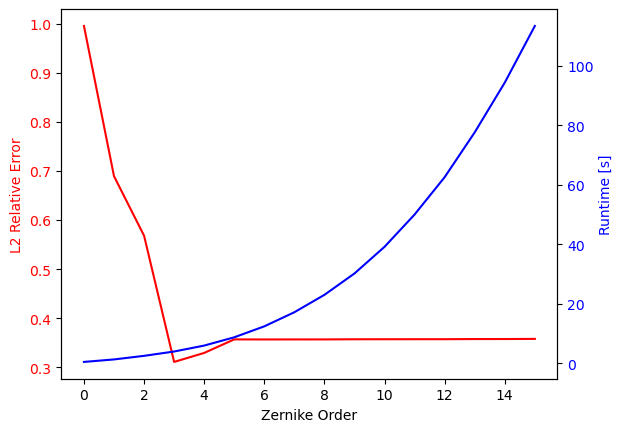

In [57]:
#Plotting
fig, ax1 = plt.subplots()

c1 = 'r'
ax1.set_xlabel('Zernike Order')
ax1.set_ylabel('L2 Relative Error', color=c1)
ax1.plot(errs, color=c1)
ax1.tick_params(axis='y',labelcolor=c1)

c2 = 'b'
ax2 = ax1.twinx()
ax2.set_ylabel('Runtime [s]', color=c2)
ax2.plot(times, color=c2)
ax2.tick_params(axis='y',labelcolor=c2)

#plt.savefig('/home/joe/Pictures/Polygon Tally/error and runtime')

Text(0, 0.5, '$L^{oo}$ norm')

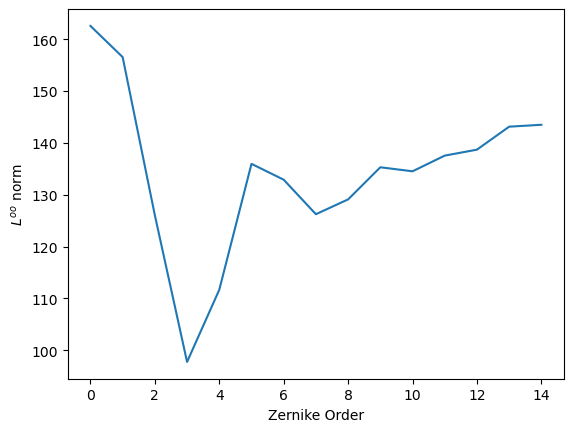

In [58]:
n = 15

p,R0 = 8,5
glip = {'p':p, 'R0':R0}

x,y = gen_polygon_cart(**glip)

f1 = input_function(x,y)
f2 = 0

errs = []
for i in range(n):
    f2 += orthonormal_f_n(i,**glip)
    
    err = np.max(f1-f2)
    errs.append(err)

plt.plot(errs)
plt.xlabel('Zernike Order')
plt.ylabel('$L^{oo}$ norm')
#plt.savefig('/home/joe/Pictures/Polygon Tally/Linf_norm')

In [68]:
def f_mn_orthonormal(n,m,p,R0):
    f = f_mn(n,m,p,R0)

    #Stuff
    p, R0 = 8, 5
    alpha = pi/p

    glorp = {'n':9, 'm':3}
    
    #Gleeple
    theta = np.linspace(0,2*pi,gas)
    dtheta = theta[1]
    
    R = r_alpha(theta,R0,alpha)
    dr = R / (gas-1)
    r = np.linspace(0,R,gas)

    #Normalizing
    c = np.sum(1/pi * f**2 * r * dr * dtheta)
    f /= c**(.5)
    print(np.sum(1/pi * f**2 * r * dr * dtheta))
    return f

def f_n_orthonormal(n,p,R0):
    ms = np.arange(-n,n+1,2)
    toRet = 0
    
    for m in ms:
        toRet += f_mn_orthonormal(n,m,p,R0)

    return toRet

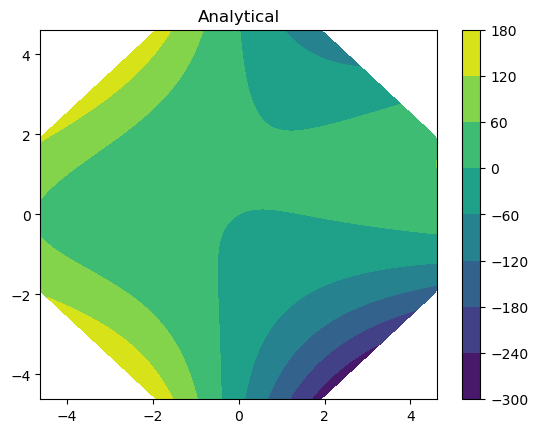

1.0000000000000002
---------------0---------------


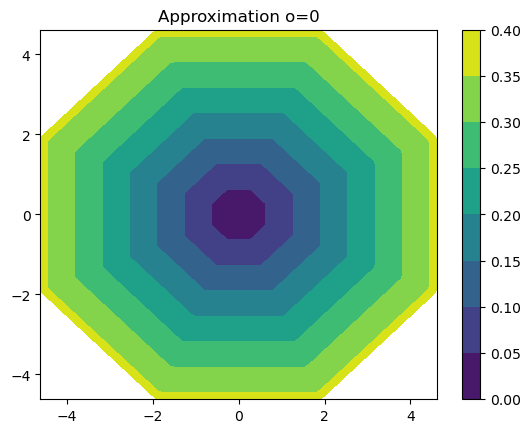

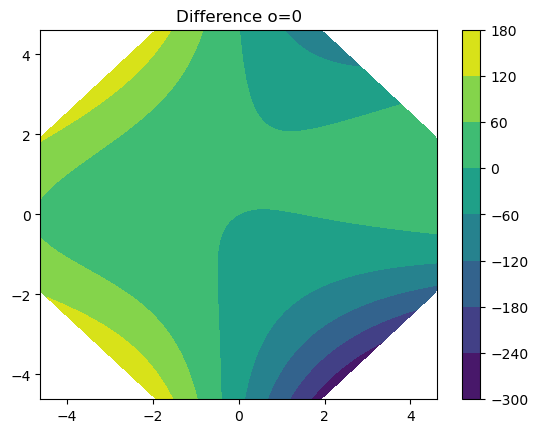

0.9999999999999999
1.0000000000000002
---------------1---------------


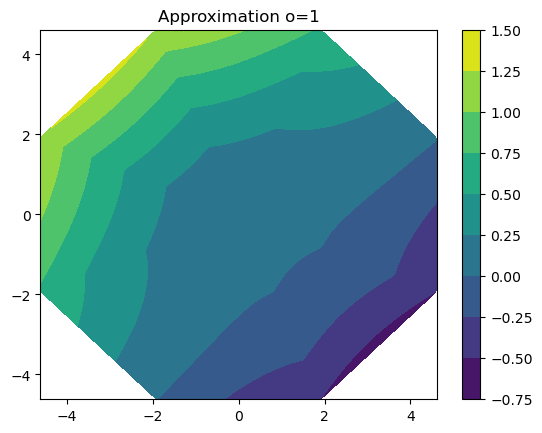

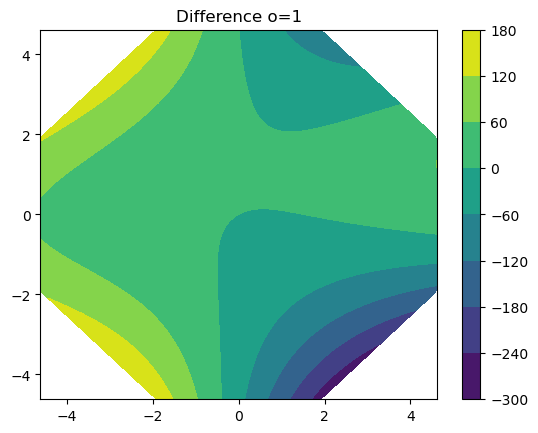

0.9999999999999999
1.0000000000000002
0.9999999999999999
---------------2---------------


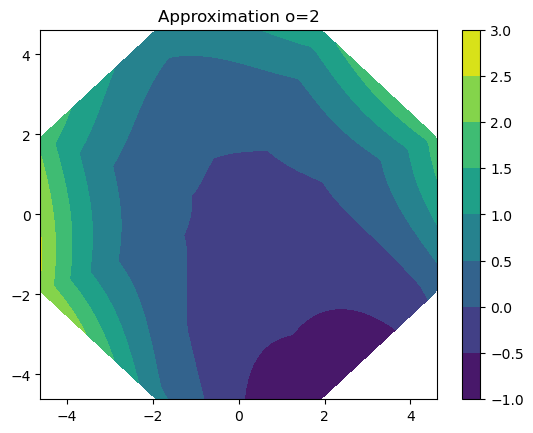

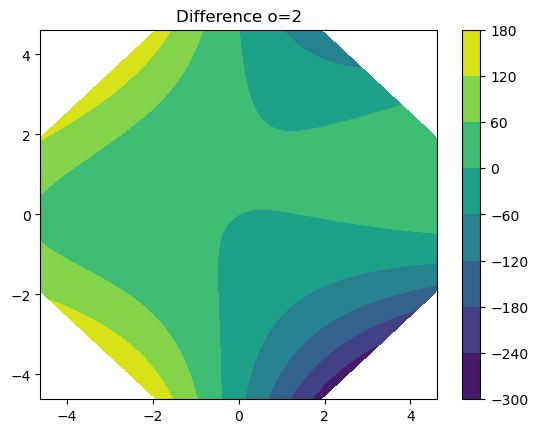

1.0000000000000004
1.0
0.9999999999999997
0.9999999999999999
---------------3---------------


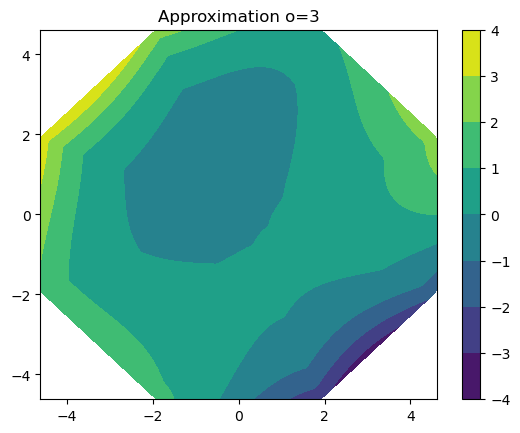

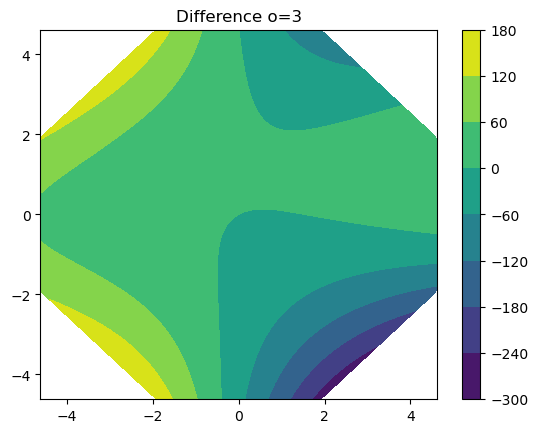

1.0
1.0
1.0
1.0
1.0
---------------4---------------


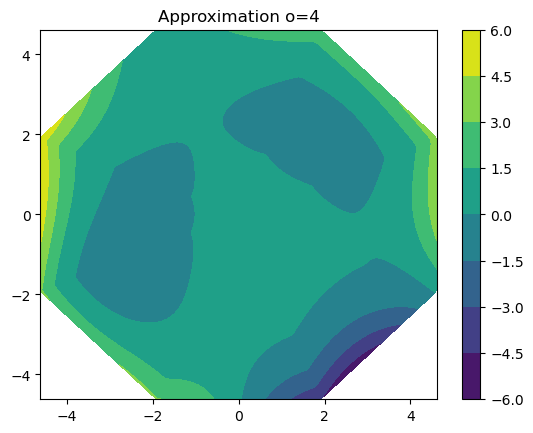

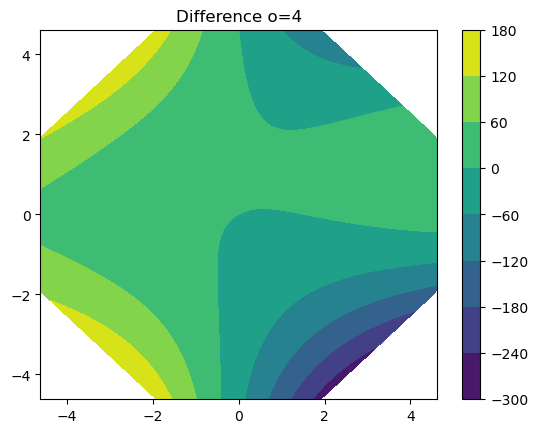

1.0
0.9999999999999998
0.9999999999999999
1.0
1.0
1.0000000000000002
---------------5---------------


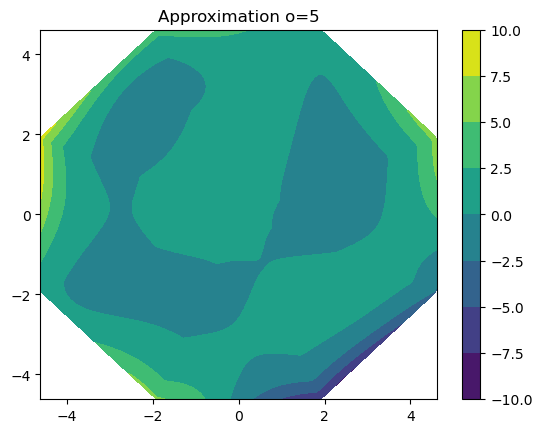

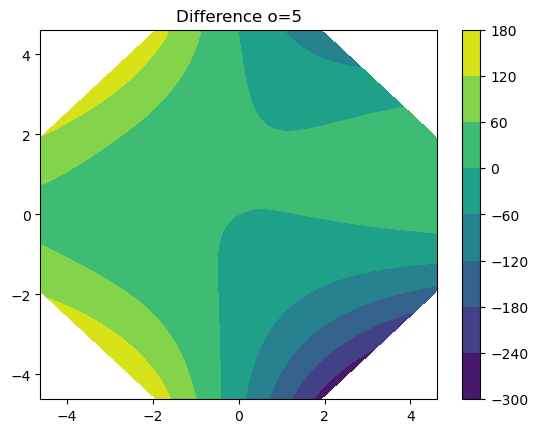

0.9999999999999999
1.0000000000000002
0.9999999999999999
0.9999999999999999
1.0000000000000002
1.0
1.0000000000000002
---------------6---------------


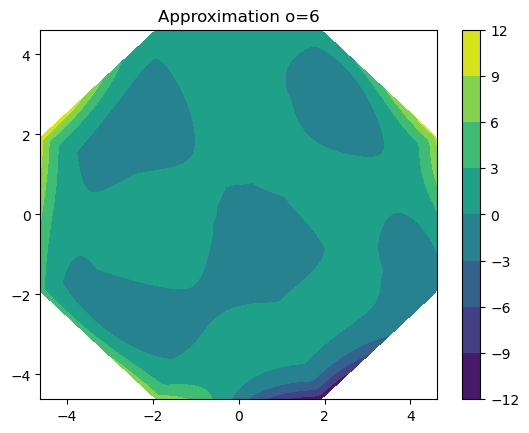

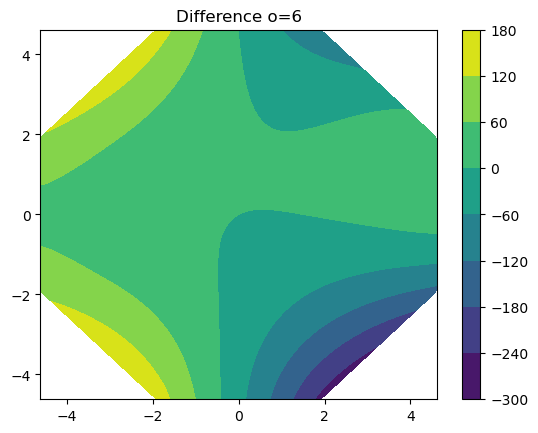

0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0000000000000002
---------------7---------------


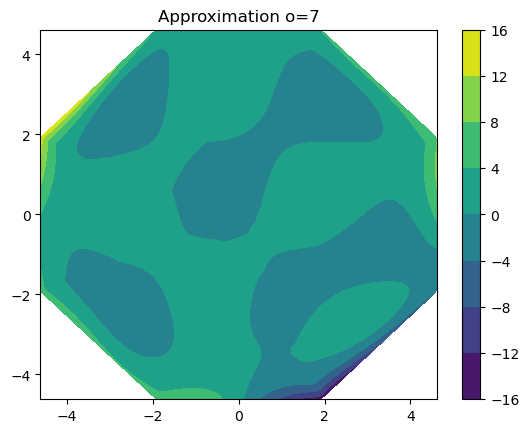

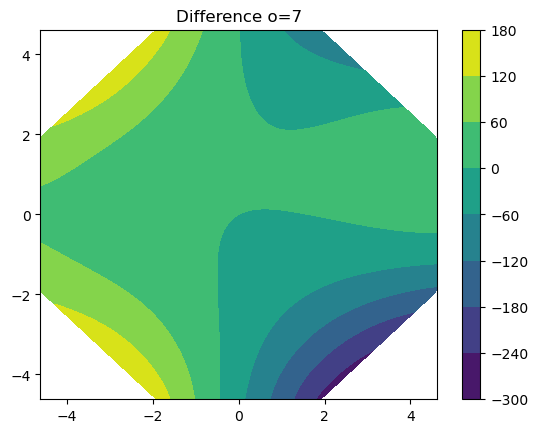

1.0
1.0
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999999
1.0
0.9999999999999998
0.9999999999999999
---------------8---------------


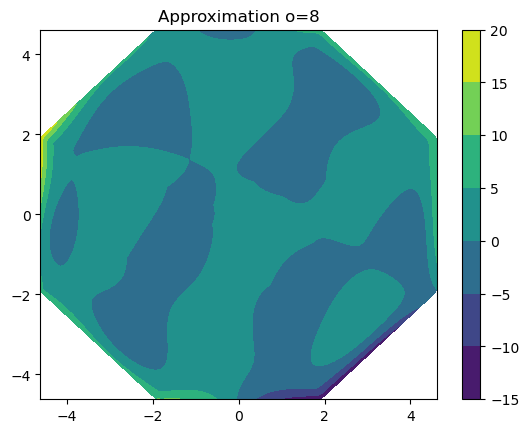

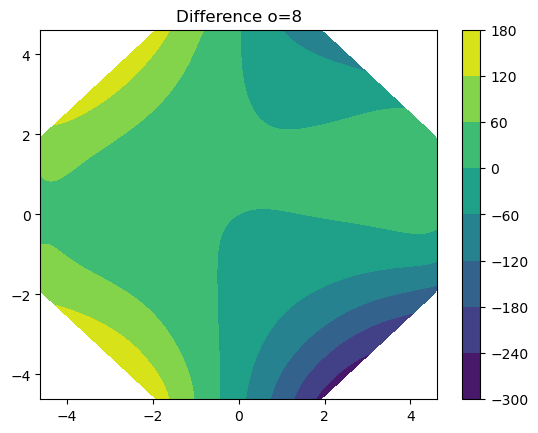

1.0
0.9999999999999999
1.0
0.9999999999999997
1.0
1.0
1.0000000000000002
1.0
1.0
1.0
---------------9---------------


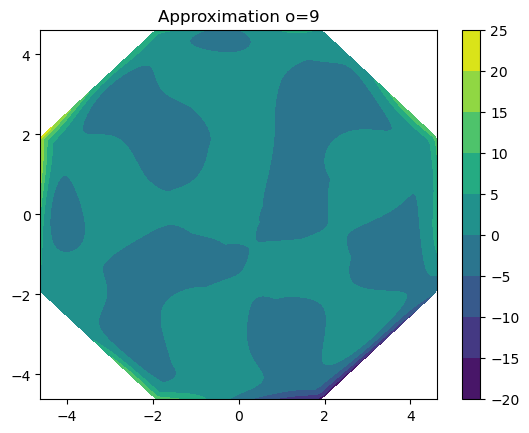

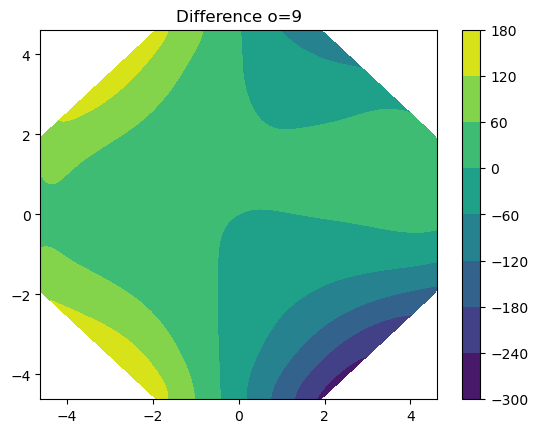

In [69]:
#"Orthonormal" Plotting
max_order = 10
x,y = gen_polygon_cart(**glip)
f1 = input_function(x,y)

#Analytical Plotting
fig, ax = plt.subplots()
ax.set_title('Analytical')
plot = ax.contourf(x,y,f1)
cbar = fig.colorbar(plot)
plt.show()

#Approximation
f2 = 0
for i in range(max_order):
    f2 += f_n_orthonormal(i,**glip)

    print('---------------{}---------------'.format(i))
    fig, ax = plt.subplots()
    ax.set_title('Approximation o={}'.format(i))
    plot = ax.contourf(x,y,f2)
    cbar = fig.colorbar(plot)
    plt.show()

    fig, ax = plt.subplots()
    ax.set_title('Difference o={}'.format(i))
    plot = ax.contourf(x,y,f1-f2)
    cbar = fig.colorbar(plot)
    plt.show()

### Plotting

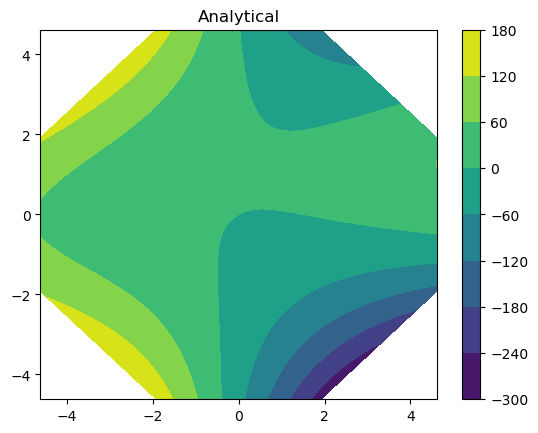

---------------0---------------


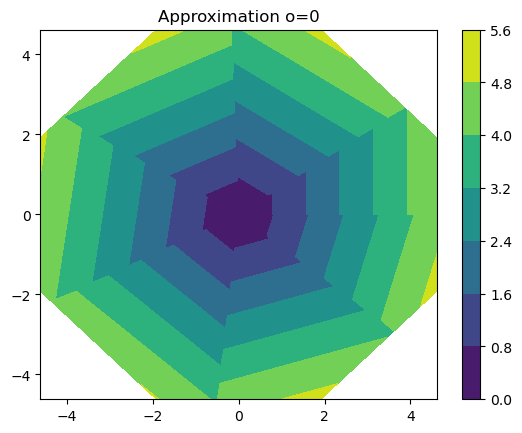

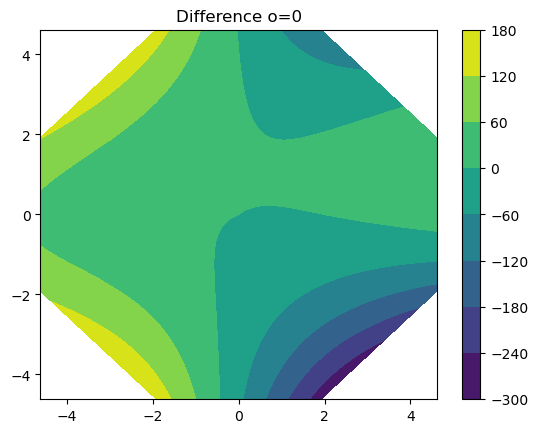

---------------1---------------


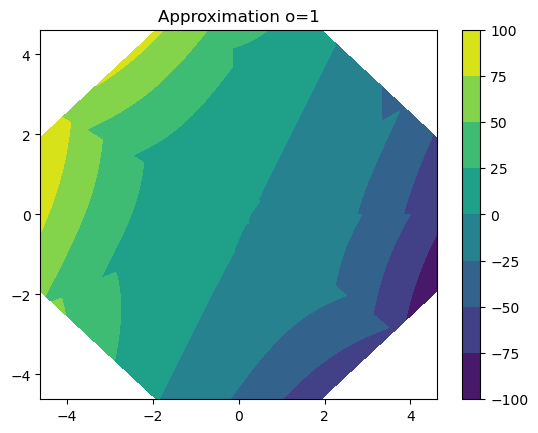

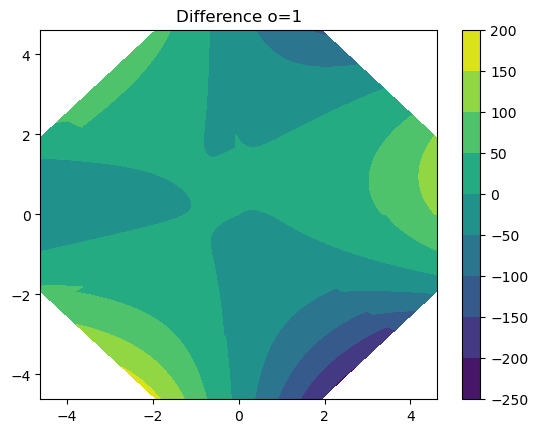

---------------2---------------


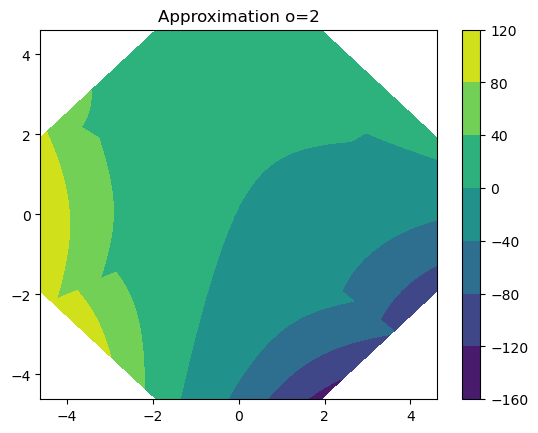

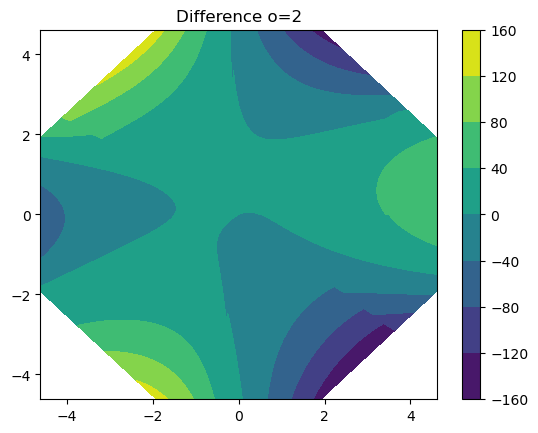

---------------3---------------


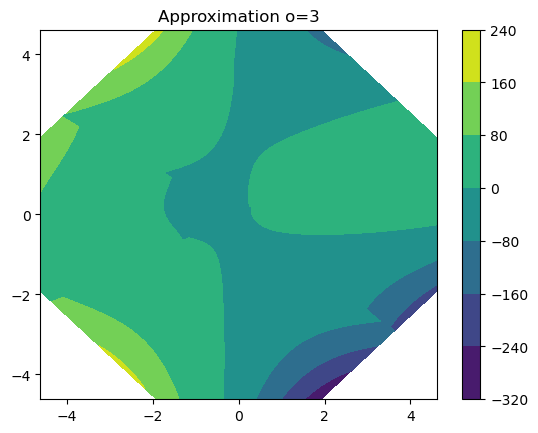

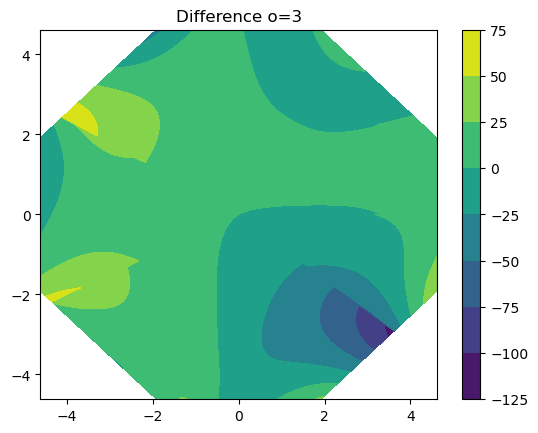

---------------4---------------


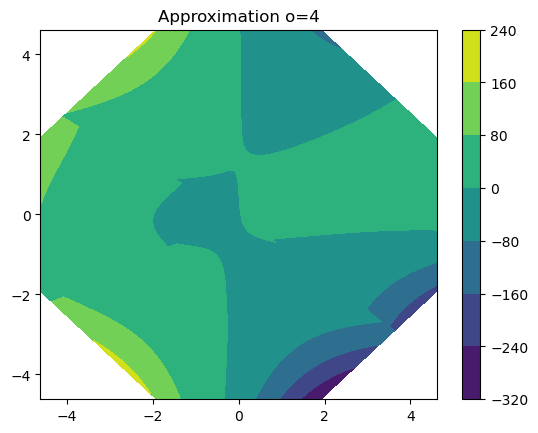

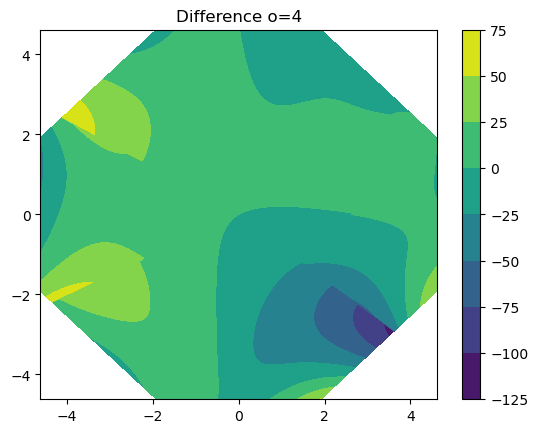

---------------5---------------


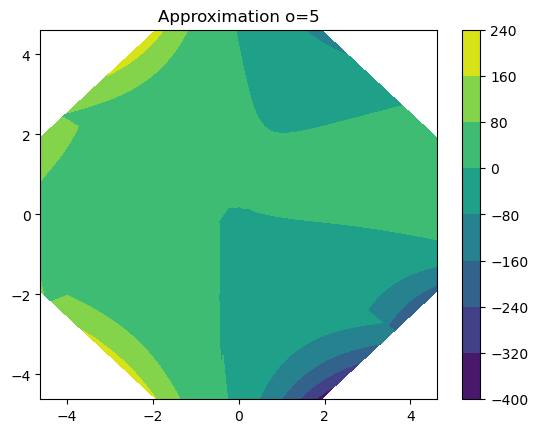

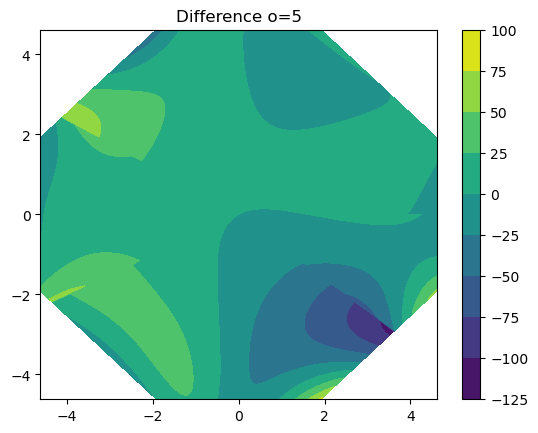

---------------6---------------


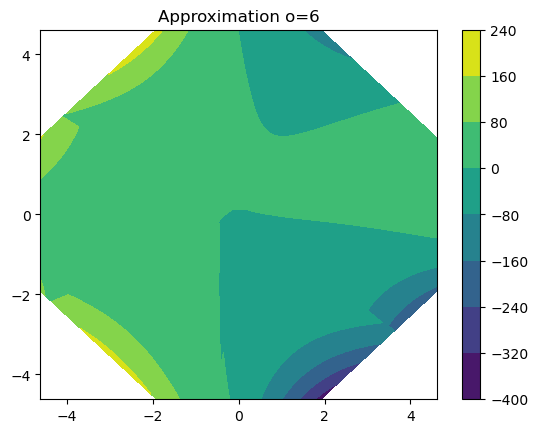

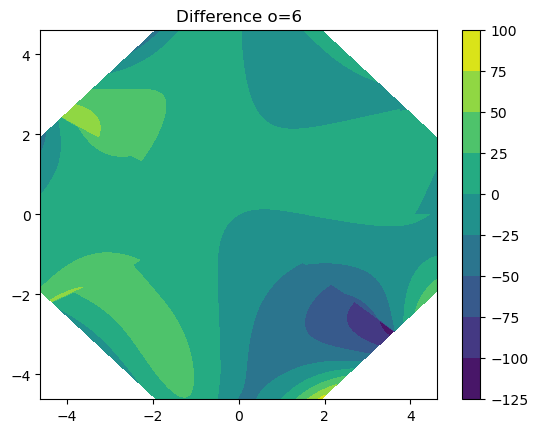

---------------7---------------


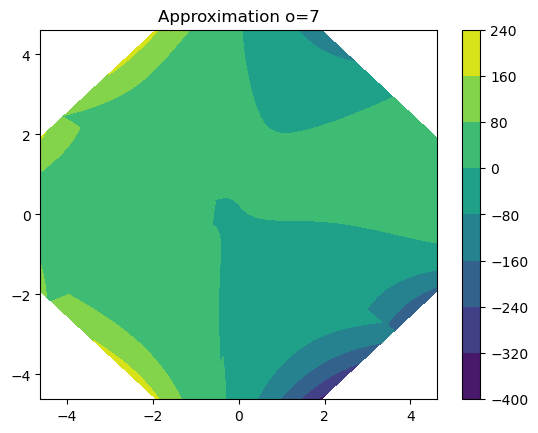

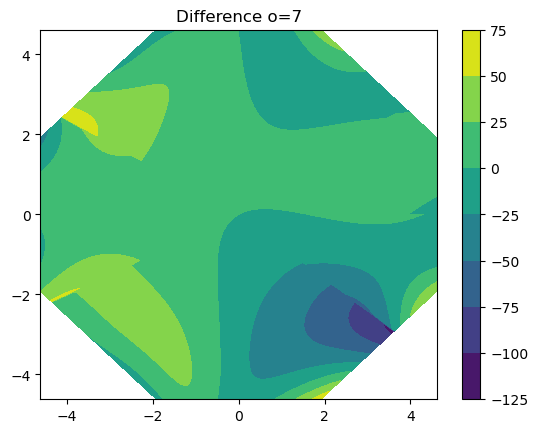

---------------8---------------


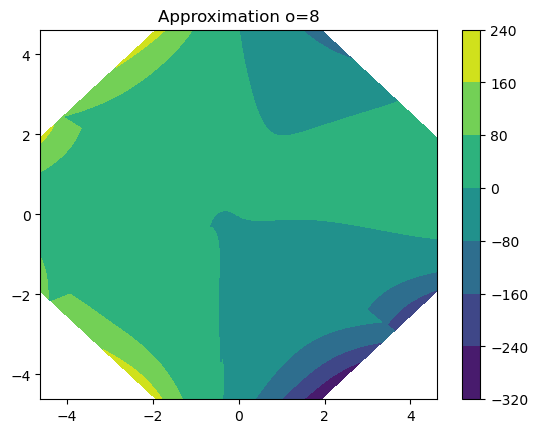

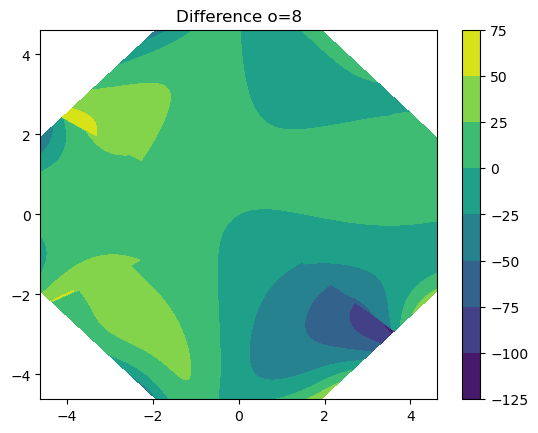

---------------9---------------


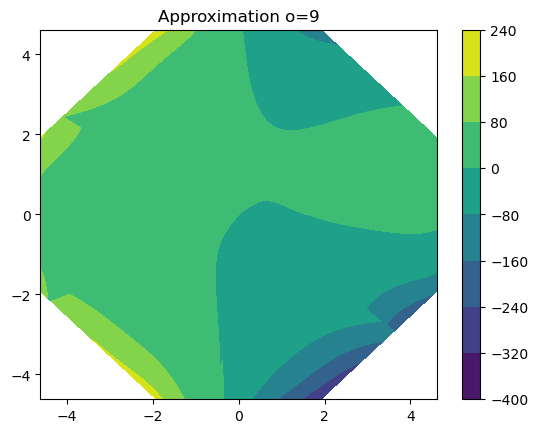

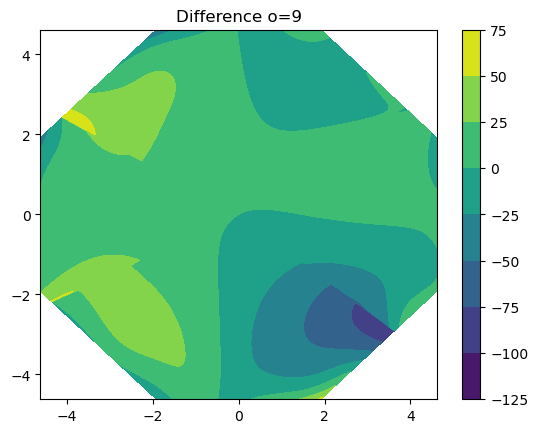

In [6]:
path = '/home/joe/Pictures/Polygon Tally/toSend/'

max_order = 10
x,y = gen_polygon_cart(**glip)
f1 = input_function(x,y)

#Analytical Plotting
fig, ax = plt.subplots()
ax.set_title('Analytical')
plot = ax.contourf(x,y,f1)
cbar = fig.colorbar(plot)
#plt.savefig(path+'analytical')
plt.show()

#Approximation
f2 = 0
for i in range(max_order):
    f2 += f_n(i,**glip)

    print('---------------{}---------------'.format(i))
    #Plotting Approx
    fig, ax = plt.subplots()
    ax.set_title('Approximation o={}'.format(i))
    plot = ax.contourf(x,y,f2)
    cbar = fig.colorbar(plot)
#    plt.savefig(path+'abs/approx_o{}'.format(i))
    plt.show()

    #Plotting Difference
    fig, ax = plt.subplots()
    ax.set_title('Difference o={}'.format(i))
    plot = ax.contourf(x,y,f1-f2)
    cbar = fig.colorbar(plot)
#    plt.savefig(path+'diff/diff_o{}'.format(i))
    plt.show()

In [9]:
n = 15
p = 8
R0 = 5

x,y = gen_polygon_cart(p,R0)
f1 = input_function(x,y)

errs = []
times = []

t0 = time.time()
for j in range(n+1):
    f2 = 0
    for i in range(j+1):
        f2 += f_n(i,p,R0)
    err = la.norm(f1-f2,2) / la.norm(f1,2)
    te = time.time()
    errs.append(err)
    print('-----{}-----'.format(j))
    print('time:',te-t0)
    print('error:', errs[j])
    times.append(te-t0)

-----0-----
time: 0.691230297088623
error: 0.9965890049145636
-----1-----
time: 1.3808622360229492
error: 0.7300964679105862
-----2-----
time: 2.413386344909668
error: 0.622797828960669
-----3-----
time: 3.923530101776123
error: 0.29728046800274077
-----4-----
time: 6.092796087265015
error: 0.30529208651736206
-----5-----
time: 9.241793394088745
error: 0.3206580378150887
-----6-----
time: 13.309924125671387
error: 0.320461906355472
-----7-----
time: 18.292875289916992
error: 0.31997193951593583
-----8-----
time: 24.37188196182251
error: 0.3199497387619709
-----9-----
time: 31.778782606124878
error: 0.3195378553619232
-----10-----
time: 40.758731842041016
error: 0.3194600237476286
-----11-----
time: 51.570053577423096
error: 0.3189933372798481
-----12-----
time: 64.49091863632202
error: 0.3189626634196493
-----13-----
time: 80.45402359962463
error: 0.31883504816587466
-----14-----
time: 98.27187705039978
error: 0.3188263944595498
-----15-----
time: 119.88486361503601
error: 0.3187856837

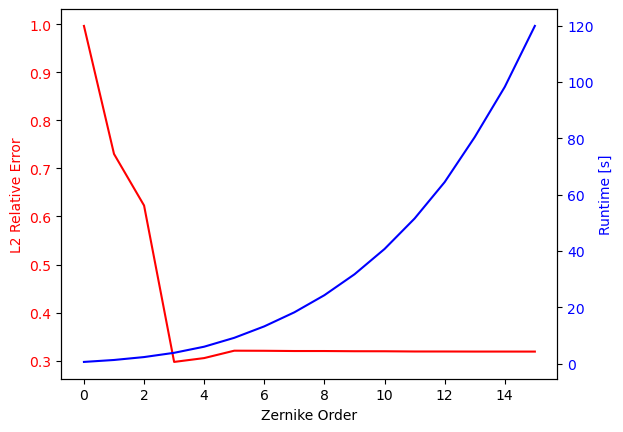

In [11]:
#Plotting
fig, ax1 = plt.subplots()

c1 = 'r'
ax1.set_xlabel('Zernike Order')
ax1.set_ylabel('L2 Relative Error', color=c1)
ax1.plot(errs, color=c1)
ax1.tick_params(axis='y',labelcolor=c1)

c2 = 'b'
ax2 = ax1.twinx()
ax2.set_ylabel('Runtime [s]', color=c2)
ax2.plot(times, color=c2)
ax2.tick_params(axis='y',labelcolor=c2)

plt.savefig('/home/joe/Pictures/Polygon Tally/error and runtime')

In [9]:
#Reduction in Runtime
a = 0.007137775421142578/0.8221111297607422
(1-a) * 100

99.13177487048254

### $L^{oo}$ Norm

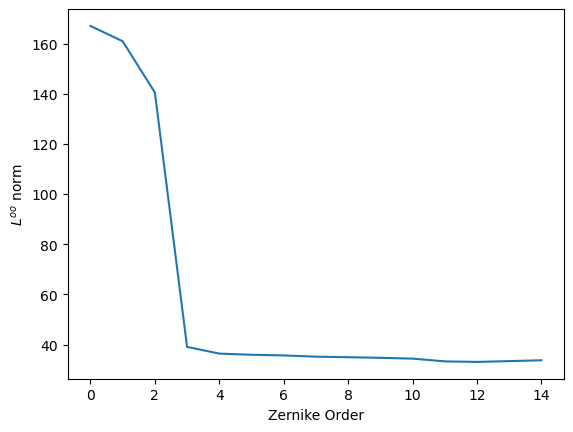

In [8]:
n = 15

p,R0 = 8,5
glip = {'p':p, 'R0':R0}

x,y = gen_polygon_cart(**glip)

f1 = input_function(x,y)
f2 = 0

errs = []
for i in range(n):
    f2 += f_n(i,**glip)
    
    err = np.max(f1-f2)
    errs.append(err)

plt.plot(errs)
plt.xlabel('Zernike Order')
plt.ylabel('$L^{oo}$ norm')
plt.savefig('/home/joe/Pictures/Polygon Tally/Linf_norm')

### Gleep

In [26]:
a = np.ones((1,5))
b = np.array([1,2,3,4,5])
err1 = la.norm(a-b,2) / la.norm(a)

c = np.ones((2,5))
d = np.array([[1,2,3,4,5],[1,2,3,4,5]])
err2 = la.norm(a-b,2) / la.norm(a)

print(err1,err2)

2.449489742783178 2.449489742783178


In [24]:
a = np.ones((2,5))
b = np.array([[1,2,3,4,5],[1,2,3,4,5]])

err = la.norm(a-b,2) / la.norm(a)
err

2.449489742783178

In [10]:
#Looking at the arrays manually
n = 10

p,R0 = 8,5
glip = {'p':p, 'R0':R0}

x,y = gen_polygon_cart(**glip)

f1 = input_function(x,y)
print('-----analytical-----')
print(f1[0,:])
f2 = f_n(n,**glip)
print('-----approximation-----')
print(f2[0,:])
print('-----difference-----')
print(np.sum(f1-f2))

-----analytical-----
[0 -0.013829 -0.027573 -0.041231 -0.054804 -0.068291 -0.081693 -0.095009 -0.10824 -0.12138 -0.13444 -0.14742 -0.16031 -0.17311 -0.18583 -0.19846 -0.21101 -0.22347 -0.23584 -0.24813 -0.26034 -0.27245 -0.28449 -0.29644 -0.3083 -0.32007 -0.33177 -0.34337 -0.35489 -0.36633 -0.37768 -0.38894 -0.40012 -0.41121 -0.42222 -0.43314 -0.44397 -0.45472 -0.46539 -0.47597 -0.48646 -0.49687 -0.50719 -0.51743 -0.52758 -0.53765 -0.54763 -0.55752 -0.56733 -0.57706 -0.5867 -0.59625 -0.60572 -0.6151 -0.62439 -0.63361 -0.64273 -0.65177 -0.66072 -0.66959 -0.67838 -0.68707 -0.69569 -0.70421 -0.71265 -0.72101 -0.72928 -0.73746 -0.74556 -0.75358 -0.76151 -0.76935 -0.7771 -0.78478 -0.79236 -0.79986 -0.80728 -0.81461 -0.82185 -0.82901 -0.83608 -0.84307 -0.84997 -0.85679 -0.86352 -0.87016 -0.87672 -0.8832 -0.88958 -0.89589 -0.9021 -0.90824 -0.91428 -0.92024 -0.92612 -0.93191 -0.93761 -0.94323 -0.94877 -0.95421 -0.95957 -0.96485 -0.97004 -0.97515 -0.98017 -0.9851 -0.98995 -0.99472 -0.99939 -1.0

-----0-----


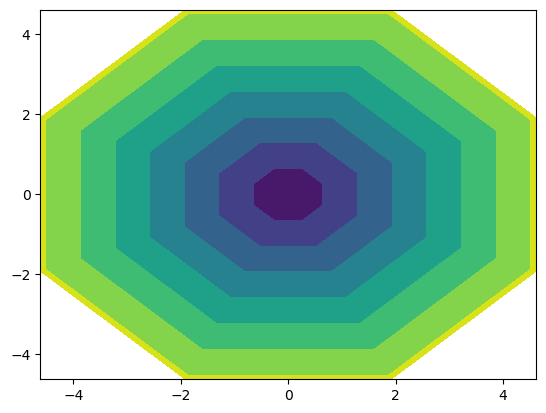

-----1-----


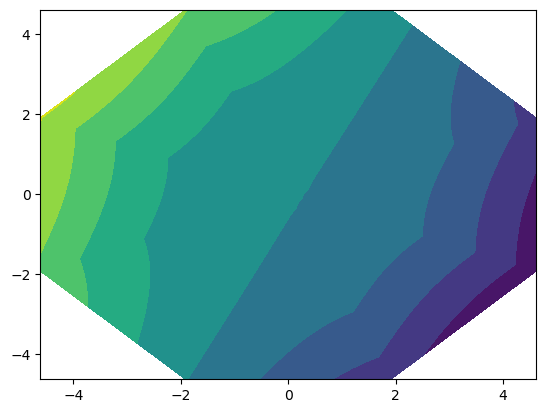

-----2-----


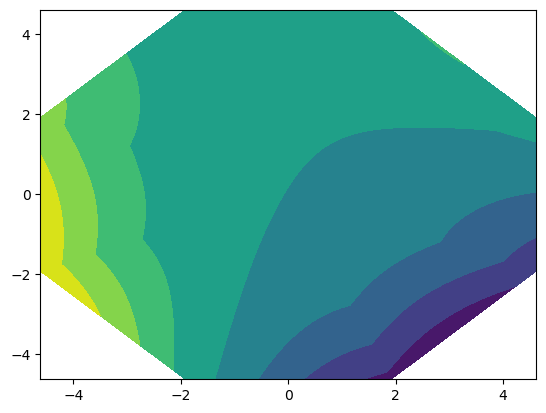

-----3-----


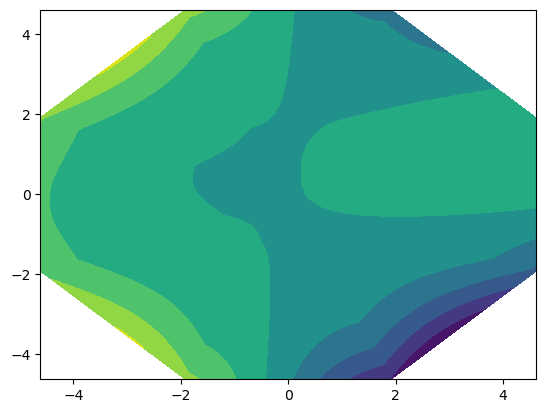

-----4-----


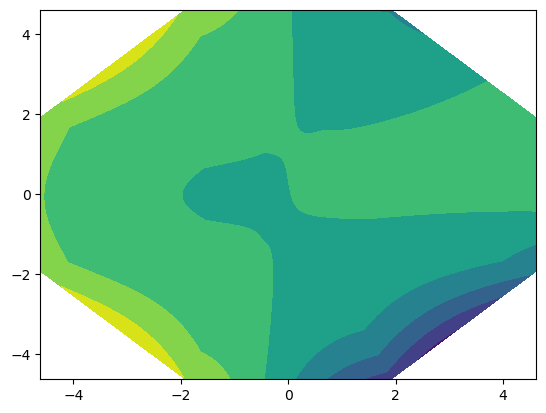

-----5-----


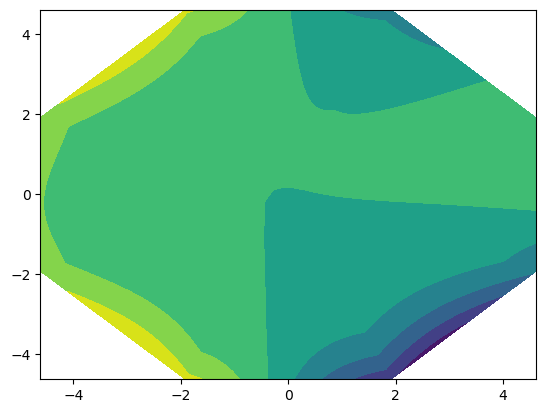

-----6-----


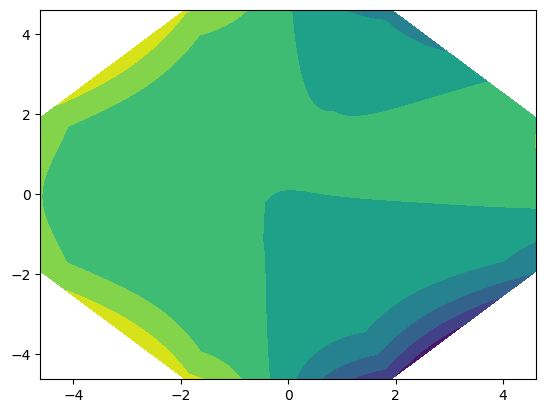

-----7-----


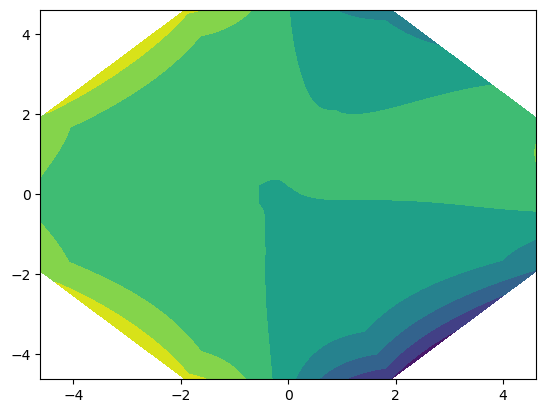

-----8-----


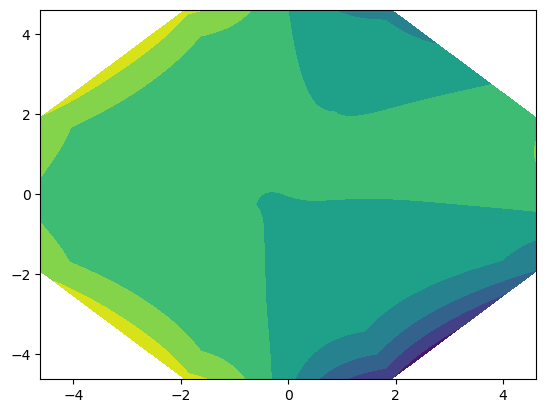

-----9-----


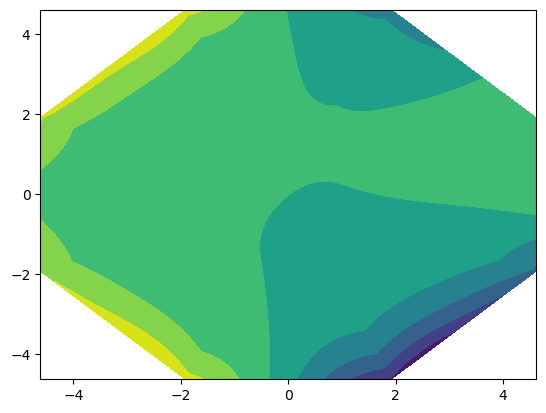

In [11]:
#Looking at each zernike
n = 10

p,R0 = 8,5
glip = {'p':p, 'R0':R0}

x,y = gen_polygon_cart(**glip)

f1 = input_function(x,y)

f2 = 0
for i in range(n):
    f2 += f_n(i,**glip)
    print('-----{}-----'.format(i))
    plotter(x,y,f2)

In [14]:
n = 15

p,R0 = 15,8
glip = {'p':p, 'R0':R0}

x,y = gen_polygon_cart(**glip)
f1 = input_function(x,y)

times = []
errs = []

ti = time.time()
for i in range(n):
    f2 = f_n(i,**glip)
    err = la.norm(f1-f2,2) / la.norm(f1,2)
    te = time.time()

    diff = f2 - f1
    print(np.sum(f2))
    
    runtime = te-ti
    times.append(runtime)
    errs.append(err)

    print('-----{}-----'.format(i))
#    print('time [s]:', runtime)
#    print('error:', err)

49261727.47938023
-----0-----
-788227.991226764
-----1-----
222133.95073789943
-----2-----
792242.154579818
-----3-----
2648.653423269474
-----4-----
-47910.69370744888
-----5-----
-781.354421213689
-----6-----
-334.92174328573947
-----7-----
1545.0305663709096
-----8-----
-1743.5236407420957
-----9-----
1556.3619513723736
-----10-----
1477.932843389252
-----11-----
-5406.635690281794
-----12-----
-1964.9909025763473
-----13-----
6616.655966514834
-----14-----


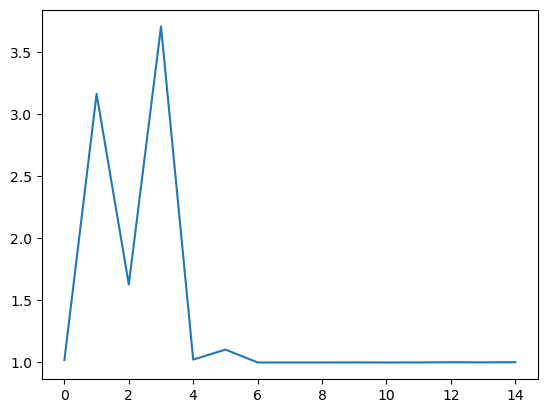

In [13]:
plt.plot(errs)
plt.show()

### BLEH

In [6]:
#Checking the runtimes
f = 0
st = time.time()
for i in range(8):
    f += f_n(i,8,5)
    et = time.time()
    print('-----{}-----'.format(i))
    print(et-st)

-----0-----
0.6402723789215088
-----1-----
1.7839131355285645
-----2-----
3.4915356636047363
-----3-----
6.151231288909912
-----4-----
9.621975898742676
-----5-----
13.682746410369873
-----6-----
18.489720106124878
-----7-----
23.907148838043213


In [58]:
def testing3(n,m,p,R0):
    alpha = pi/p

    r,theta = gen_polygon_polar(p,R0)
    R = np.zeros_like(theta)

    glorp = np.linspace(0,2*pi,gas)
    gleep = r_alpha(glorp,R0,alpha)
    
    for i in range(len(theta[0])):
        R[i,:] = gleep[i]

    rho = r / R
    phi = theta

    Z = zernike_m(n,m,rho,phi)
    K = Z * r / R
    c = c_mn(n,m,p,R0)

    #toRet = c * K
    return #toRet

ti = time.time()
testing3(**test)
te = time.time()
te-ti

0.5830676555633545

In [89]:
#DO NOT RUN!!! Testing the f_mn swap
def f_mn(n,m,p,R0):
    alpha = pi/p

    r,theta = gen_polygon_polar(p,R0)
    R = np.zeros_like(theta)

    for i in range(len(theta[0])):
        for j in range(len(theta[:,0])):
            R[i,j] = r_alpha(theta[i,j],R0,alpha)

    rho = r / R
    phi = theta

    Z = zernike_m(n,m,rho,phi)
    K = Z * r / R
    c = c_mn(n,m,p,R0)

    toRet = c * K
    return toRet

def testing1(n,m,p,R0):
    ti = time.time()
    alpha = pi/p

    r,theta = gen_polygon_polar(p,R0)
    R = np.zeros_like(theta)

    for i in range(len(theta[0])):
        for j in range(len(theta[:,0])):
            R[i,j] = r_alpha(theta[i,j],R0,alpha)
    te = time.time()
    runtime = te-ti
    return runtime#,r#,theta

def testing2(n,m,p,R0):
    alpha = pi/p

    r,theta = gen_polygon_polar(p,R0)
    R = np.zeros_like(theta)

    glorp = np.linspace(0,2*pi,gas)
    gleep = r_alpha(glorp,R0,alpha)
    
    for i in range(len(theta[0])):
        R[i,:] = gleep[i]

    rho = r / R
    phi = theta

    Z = zernike_m(n,m,rho,phi)
    K = Z * r / R
    c = c_mn(n,m,p,R0)

    toRet = c * K
    return toRet

testing2(**test)

test = {'n': 1, 'm': 1, 'p': 4, 'R0': 5}
testing1(**test)

0.0007047653198242188